### DLモデル　改訂版

### 必要ライブラリの導入

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# 共通事前処理

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.2f}'.format

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

### データ準備

#### データ読み込み

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)

x_org = mnist.data.values
y_org = mnist.target.astype(int).values

# 結果確認
print(x_org.shape, y_org.shape)
print(y_org[:5])

(70000, 784) (70000,)
[5 0 4 1 9]


### データ加工

#### xの正規化

In [4]:
# xの正規化
x_norm = x_org / 255.0

# 先頭にダミー変数(1)を追加
x_all = np.insert(x_norm, 0, 1, axis=1)

print('ダミー変数追加後', x_all.shape)

ダミー変数追加後 (70000, 785)


#### yのone hot vector化

In [5]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False,categories='auto')
y_all_ohe = ohe.fit_transform(y_org.reshape(-1, 1))

print('One Hot Vector化前', y_org.shape)
print('One Hot Vector化後', y_all_ohe.shape)

One Hot Vector化前 (70000,)
One Hot Vector化後 (70000, 10)


#### 訓練データ・テストエータへの分割

In [6]:
from sklearn.model_selection import train_test_split
x_train_np, x_test_np,y_train_np, y_test_np,y_train_ohe_np, y_test_ohe_np = train_test_split(
    x_all, y_org, y_all_ohe, train_size=60000, test_size=10000, shuffle=False)

# 結果確認
print('訓練データ', x_train_np.shape, y_train_np.shape, y_train_ohe_np.shape)
print('テストデータ', x_test_np.shape, y_test_np.shape, y_test_ohe_np.shape)

訓練データ (60000, 785) (60000,) (60000, 10)
テストデータ (10000, 785) (10000,) (10000, 10)


#### torch変数に変換


### GPU操作

 #### GPU 存在チェック

In [7]:
import torch

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


#### Tensor型に変換

In [8]:
# NumPy変数をTensor変数に変換
x_train = torch.Tensor(x_train_np).float()
y_train = torch.Tensor(y_train_np).float()
y_train_ohe = torch.Tensor(y_train_ohe_np).float()
x_test = torch.Tensor(x_test_np).float()
y_test = torch.Tensor(y_test_np).float()
y_test_ohe = torch.Tensor(y_test_ohe_np).float()

# テストデータに関してはこのタイミングでGPUに送付する
x_test_gpu = x_test.to(device)
y_test_gpu = y_test.to(device)
y_test_ohe_gpu = y_test_ohe.to(device)

 ### データ内容の確認

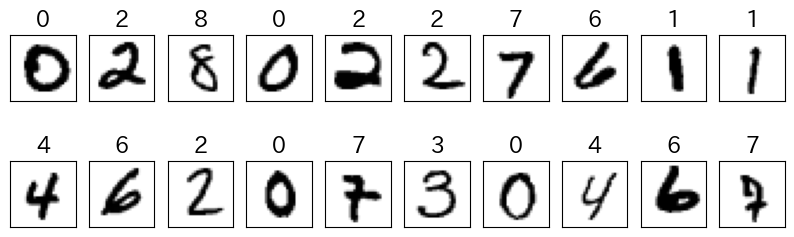

In [16]:
N = 20

# テストデータから20件をランダムに抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test[indexes]
y_selected = y_test[indexes]

# 20件データのイメージと正解ラベルを表示
plt.figure(figsize=(10, 3))
for i in range(N):
    # 描画位置指定
    ax = plt.subplot(2, int(N/2), i + 1)

    # イメージ表示(列はダミー変数を落とす)
    ax.imshow(x_selected[i,1:].reshape(28, 28), cmap='gray_r')

    # 正解ラベル表示
    ax.set_title(f'{int(y_selected[i]):d}', fontsize=16)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 関数定義

#### 汎用関数

In [17]:
import torch.nn as nn
sigmoid = nn.Sigmoid()
softmax = nn.Softmax(dim=1)

#### 予測関数

In [18]:
def pred(x, W):
    return softmax(x @ W)

#### 損失関数(交差エントロピー関数)

In [19]:
def cross_entropy(yt_ohe, yp_ohe):
    return -torch.mean(torch.sum(yt_ohe * torch.log(yp_ohe), dim=1))

#### evaluate(損失と精度を計算)

In [20]:
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_ohe, x_dum, V, W):

    # テストデータに対して隠れ層の値を計算
    b_test = sigmoid(x_test @ V)

    # ダミー変数追加
    b1_test = torch.cat((x_dum, b_test), dim=1)

    # 予測値算出
    yp_test_ohe = softmax(b1_test @ W)

    # ラベル値算出
    yp_test = torch.argmax(yp_test_ohe, dim=1)

    # 損失計算(item関数でスカラー化)
    loss = cross_entropy(y_test_ohe, yp_test_ohe).item()

    # 精度計算(item関数でスカラー化)
    score = (y_test == yp_test).float().mean().item()

    return score, loss

### ミニバッチ処理

#### 関数Indexes定義

In [21]:
class Indexes():

    # コンストラクタ
    def __init__(self, total, size):
        # 配列全体の大きさ
        self.total   = total
        # batchサイズ
        self.size    = size
        #　作業用indexes 初期値はNULLにしておく
        self.indexes = np.zeros(0)

    # index取得関数
    def next_index(self):
        next_flag = False

    # bacthサイズより作業用Indexesが小さい場合はindexes再生成
        if len(self.indexes) < self.size:
            self.indexes = np.random.choice(self.total,
                self.total, replace=False)
            next_flag = True

        # 戻り用index取得と作業用indexes更新
        index = self.indexes[:self.size]
        self.indexes = self.indexes[self.size:]
        return index, next_flag

#### 関数利用サンプル

In [22]:
# クラス初期化
# 20: 全体の配列の大きさ
# 5: 一回に取得するindexの数
indexes = Indexes(20, 5)

for i in range(6):
    # next_index関数呼び出し
    # 戻り値1:  indexのnumpy配列
    # 戻り値2: 作業用Indexの更新があったかどうか
    arr, flag = indexes.next_index()
    print(arr, flag)

[11  3  9 17 12] True
[ 2  7 18  0  8] False
[ 1 16 10 14 15] False
[19  4  5 13  6] False
[12  5 18 15 10] True
[17 19  1  2  9] False


### 学習

#### 初期化処理

In [23]:
# 隠れ層のノード数
H = 128
H1 = H + 1
# M: 訓練用系列データ総数
M  = x_train.shape[0]
# D: 入力データ次元数
D = x_train.shape[1]
# N: 分類クラス数
N = y_train_ohe.shape[1]

# 繰り返し回数
nb_epoch = 2000
# ミニバッチサイズ
batch_size = 128
B = batch_size
# 学習率
alpha_np = 0.01

# 重み行列の初期設定
np.random.seed(123)
V_np = np.random.randn(D, H) / np.sqrt(D / 2)
W_np = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 評価結果記録用 (損失関数値と精度)
history1 = np.zeros((0, 3))

# ミニバッチ用関数初期化
indexes = Indexes(M, batch_size)

# 繰り返し回数カウンタ初期化
epoch = 0

# GPU転送
alpha = torch.tensor(alpha_np).float().to(device)
V = torch.tensor(V_np).float().to(device)
W = torch.tensor(W_np).float().to(device)
x_dum = torch.ones((batch_size,1)).float().to(device)
x_dum2 = torch.ones((len(x_test),1)).float().to(device)

#### 繰り返し計算

In [24]:
%%time
while epoch < nb_epoch:

    # 学習対象の選択(ミニバッチ学習法)
    index, next_flag = indexes.next_index()

    # 学習対象選択時にGPU転送を行う
    x, yt = x_train[index].to(device), y_train_ohe[index].to(device)

    # 予測値計算 (順伝播)
    a = x @ V
    b = sigmoid(a)
    b1 = torch.cat((x_dum, b), dim=1)
    u = b1 @ W
    yp = softmax(u)

    # 誤差計算
    yd = yp - yt
    bd = b * (1-b) * (yd @ W[1:].T)

    # 勾配計算
    W = W - alpha * (b1.T @ yd) / B
    V = V - alpha * (x.T @ bd) / B

    if next_flag : # 1epoch 終了後の処理
        score, loss = evaluate(x_test_gpu, y_test_gpu, y_test_ohe_gpu, x_dum2, V, W)
        history1 = np.vstack((history1, np.array([epoch, loss, score])))
        epoch = epoch + 1
        if (epoch-1) % 10 == 0:
            print(f'epoch = {epoch-1} loss = {loss:.04f} score = {score:.04f}')


epoch = 0 loss = 2.4922 score = 0.1119
epoch = 10 loss = 0.4982 score = 0.8807
epoch = 20 loss = 0.3725 score = 0.8985
epoch = 30 loss = 0.3291 score = 0.9075
epoch = 40 loss = 0.3057 score = 0.9144
epoch = 50 loss = 0.2900 score = 0.9183
epoch = 60 loss = 0.2781 score = 0.9218
epoch = 70 loss = 0.2681 score = 0.9241
epoch = 80 loss = 0.2597 score = 0.9260
epoch = 90 loss = 0.2515 score = 0.9286
epoch = 100 loss = 0.2441 score = 0.9308
epoch = 110 loss = 0.2369 score = 0.9321
epoch = 120 loss = 0.2302 score = 0.9346
epoch = 130 loss = 0.2239 score = 0.9350
epoch = 140 loss = 0.2178 score = 0.9370
epoch = 150 loss = 0.2119 score = 0.9391
epoch = 160 loss = 0.2065 score = 0.9398
epoch = 170 loss = 0.2011 score = 0.9423
epoch = 180 loss = 0.1966 score = 0.9436
epoch = 190 loss = 0.1914 score = 0.9450
epoch = 200 loss = 0.1870 score = 0.9464
epoch = 210 loss = 0.1829 score = 0.9468
epoch = 220 loss = 0.1784 score = 0.9483
epoch = 230 loss = 0.1746 score = 0.9492
epoch = 240 loss = 0.1708 s

### 結果分析

#### 損失・精度確認

In [25]:
print(f'初期状態: 損失関数:{history1[0,1]:.04f} 精度:{history1[0,2]:.04f}')
print(f'最終状態: 損失関数:{history1[-1,1]:.04f} 精度:{history1[-1,2]:.04f}')

初期状態: 損失関数:2.4922 精度:0.1119
最終状態: 損失関数:0.0645 精度:0.9791


#### 学習曲線(損失)

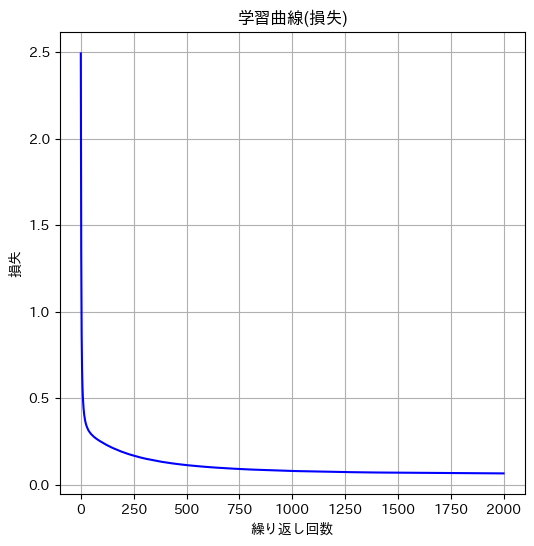

In [26]:
plt.figure(figsize=(6,6))
plt.plot(history1[:,0], history1[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
plt.show()

#### 学習曲線(精度)

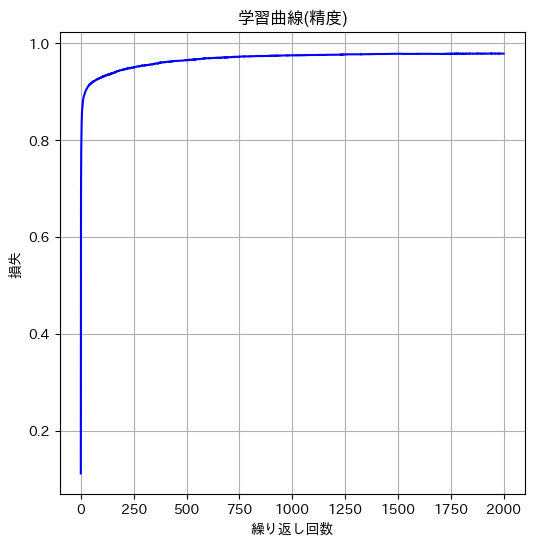

In [27]:
plt.figure(figsize=(6,6))
plt.plot(history1[:,0], history1[:,2], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(精度)')
plt.grid()
plt.show()

#### イメージで確認

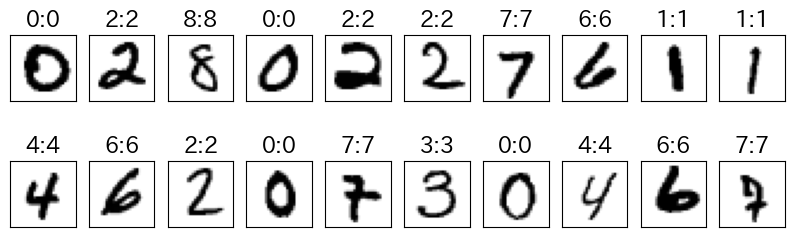

In [28]:
N = 20

# テストデータから20件をランダムに抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
x_dum3 = torch.ones((N,1)).float().to(device)
indexes = np.random.choice(y_test.shape[0], N, replace=False)

# x_orgの選択結果表示 (白黒反転)
x_selected = x_test[indexes].to(device)
y_selected = y_test[indexes].to(device)

# 予測値の計算

# テストデータに対して隠れ層の値を計算
b_test = sigmoid(x_selected @ V)

# ダミー変数追加
b1_test = torch.cat((x_dum3, b_test), dim=1)

# 予測値算出
yp_test_ohe = softmax(b1_test @ W)

# ラベル値算出
yp_test = torch.argmax(yp_test_ohe, dim=1)

# グラフ表示
plt.figure(figsize=(10, 3))
for i in range(N):

    # 描画位置指定
    ax = plt.subplot(2, int(N/2), i + 1)

    # 画像イメージ表示
    ax.imshow(x_selected[i,1:].cpu().reshape(28, 28),cmap='gray_r')

    # 正解ラベル:予測結果　の表示
    ax.set_title(f'{int(y_selected[i])}:{yp_test[i]}', fontsize=16)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### バージョン確認

In [30]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch              : 2.5.1+cu121
sklearn            : 1.6.0
japanize_matplotlib: 1.1.3
IPython            : 7.34.0
numpy              : 1.26.4
matplotlib         : 3.8.0
pandas             : 2.2.2

